In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

#Load dataset from Kaggle
https://www.kaggle.com/aakashnain/beating-everything-with-depthwise-convolution 
* Guide download files from kaggle : https://www.kaggle.com/general/74235

In [ ]:
#install kaggle
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"annengh","key":"ec53f1fb9795d4b4579a66bd28c081e1"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
#check 
#! kaggle datasets list

### Download dataset

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.28G/2.29G [00:19<00:00, 76.1MB/s]
100% 2.29G/2.29G [00:19<00:00, 127MB/s] 


In [ ]:
!unzip chest-xray-pneumonia.zip
!rm chest-xray-pneumonia.zip

clear_output()

In [ ]:
PATH = os.path.join(os.getcwd(), 'chest_xray')

train_dir = os.path.join(PATH, 'train')
val_dir = os.path.join(PATH, 'val')
test_dir = os.path.join(PATH, 'test')

In [ ]:
train_normal_dir = os.path.join(train_dir, 'NORMAL')
train_pneu_dir = os.path.join(train_dir, 'PNEUMONIA')
val_normal_dir = os.path.join(val_dir, 'NORMAL')
val_pneu_dir = os.path.join(val_dir, 'PNEUMONIA')
test_normal_dir = os.path.join(test_dir, 'NORMAL')
test_pneu_dir = os.path.join(test_dir, 'PNEUMONIA')

### Understand the data

In [ ]:
num_normal_tr = len(os.listdir(train_normal_dir))
num_pneu_tr = len(os.listdir(train_pneu_dir))

num_normal_val = len(os.listdir(val_normal_dir))
num_pneu_val = len(os.listdir(val_pneu_dir))

total_train = num_normal_tr + num_pneu_tr
total_val = num_normal_val + num_pneu_val

In [ ]:
print('total training normal images:', num_normal_tr)
print('total training pneu images:', num_pneu_tr)

print('total validation normal images:', num_normal_val)
print('total validation pneu images:', num_pneu_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training normal images: 1341
total training pneu images: 3875
total validation normal images: 8
total validation pneu images: 8
--
Total training images: 5216
Total validation images: 16


In [ ]:
batch_size = 16
epochs = 5
IMG_HEIGHT = 50
IMG_WIDTH = 50

## Data preparation

In [ ]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [ ]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 5216 images belonging to 2 classes.


In [ ]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=val_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 16 images belonging to 2 classes.


### Visualize training images

In [ ]:
sample_training_images, _ = next(train_data_gen)

In [ ]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    i = 0
    for img, ax in zip( images_arr, axes):
        i += 1
        ax.imshow(img)
        ax.axis('off')
        ax.set_xlabel(images_arr.classes[i])
    plt.tight_layout()
    plt.show()

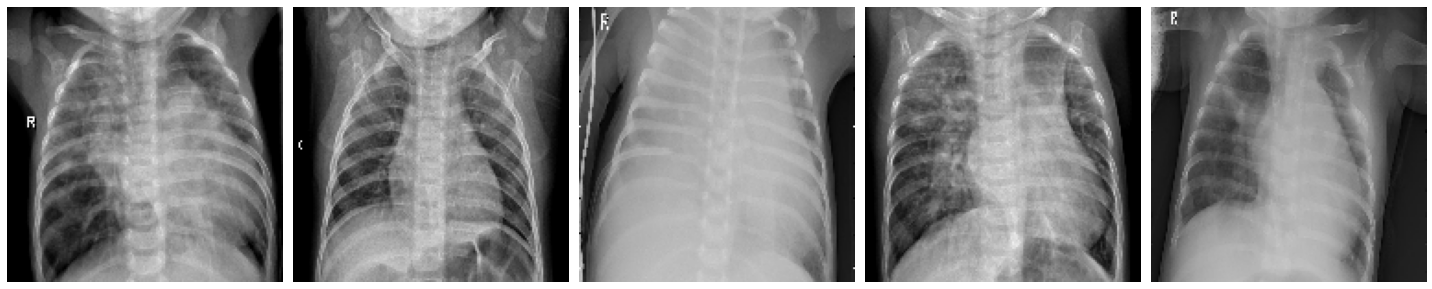

In [ ]:
plotImages(sample_training_images[:5])

## Create the model

In [ ]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    tf.keras.layers.Dropout(0.2),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 50, 50, 16)        448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 25, 25, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2304)             

### Compile the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

## Train the model

### Without class_weight

In [ ]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size,
)

Epoch 1/5
326/326 [==============================] - 68s 209ms/step - loss: 0.0582 - accuracy: 0.9801 - val_loss: 0.3716 - val_accuracy: 0.8125
Epoch 2/5
326/326 [==============================] - 67s 206ms/step - loss: 0.0514 - accuracy: 0.9793 - val_loss: 0.1644 - val_accuracy: 0.9375
Epoch 3/5
326/326 [==============================] - 67s 207ms/step - loss: 0.0449 - accuracy: 0.9831 - val_loss: 0.2855 - val_accuracy: 0.8750
Epoch 4/5
326/326 [==============================] - 67s 206ms/step - loss: 0.0395 - accuracy: 0.9850 - val_loss: 0.3301 - val_accuracy: 0.8750
Epoch 5/5
326/326 [==============================] - 68s 207ms/step - loss: 0.0346 - accuracy: 0.9860 - val_loss: 0.1999 - val_accuracy: 0.8750


### Visualize training results

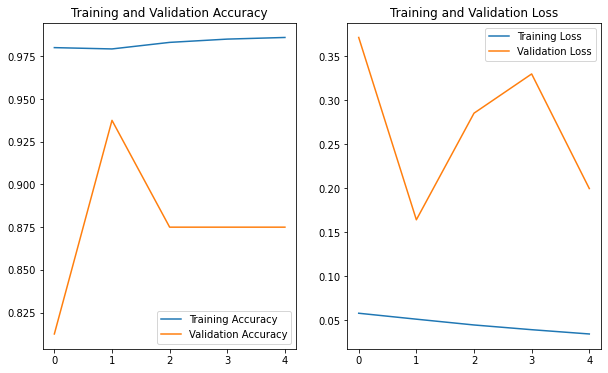

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Evaluate on Test set

In [ ]:
test_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                               directory=test_dir,
                                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                               class_mode='binary')

Found 624 images belonging to 2 classes.


In [ ]:
model.evaluate(test_data_gen)

39/39 [==============================] - 6s 155ms/step - loss: 1.4421 - accuracy: 0.7724


[1.4420580863952637, 0.7724359035491943]

In [ ]:
# Get predictions
test_preds = model.predict(test_data_gen)
test_preds[:3]

array([[0.99999845],
       [0.9999993 ],
       [1.        ]], dtype=float32)

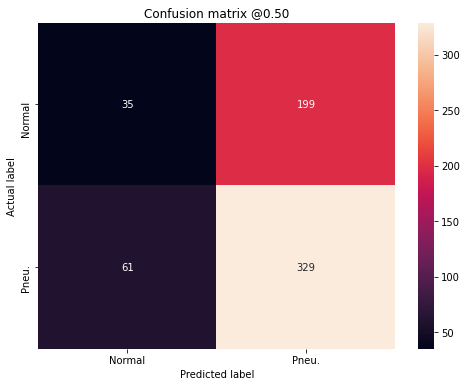

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    fig, ax = plt.subplots(figsize=(8,6))
    ax = sns.heatmap(cm, annot=True, fmt="d")
    ax.set_xticklabels(['Normal', 'Pneu.'])
    ax.set_yticklabels(['Normal', 'Pneu.'])
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')


plot_cm(test_data_gen.labels, test_preds, p=0.5)

### Define class_weight

In [ ]:
train_data_gen.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [ ]:
val_data_gen.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [ ]:
test_data_gen.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [ ]:
from sklearn.utils import class_weight

#class_weights = class_weight.compute_class_weight('balanced',
#                                                 np.unique(all_labels_train),
#                                                 all_labels_train)
#class_weights = dict(enumerate(class_weights))

weight_for_Normal = total_train/num_normal_tr/2
weight_for_Pnneu = total_train/num_pneu_tr/2

class_weights = {0: weight_for_Normal, 1: weight_for_Pnneu}
class_weights

{0: 1.9448173005219984, 1: 0.6730322580645162}

### Without class_weight

In [ ]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size,
    class_weight=class_weights)

Epoch 1/5
326/326 [==============================] - 67s 206ms/step - loss: 0.0199 - accuracy: 0.9912 - val_loss: 0.7797 - val_accuracy: 0.6875
Epoch 2/5
326/326 [==============================] - 67s 204ms/step - loss: 0.0408 - accuracy: 0.9822 - val_loss: 0.1978 - val_accuracy: 0.8750
Epoch 3/5
326/326 [==============================] - 66s 204ms/step - loss: 0.0324 - accuracy: 0.9868 - val_loss: 0.3270 - val_accuracy: 0.8750
Epoch 4/5
326/326 [==============================] - 66s 203ms/step - loss: 0.0236 - accuracy: 0.9918 - val_loss: 0.1708 - val_accuracy: 0.9375
Epoch 5/5
326/326 [==============================] - 66s 203ms/step - loss: 0.0245 - accuracy: 0.9900 - val_loss: 0.3551 - val_accuracy: 0.8750


In [ ]:
test_preds_with_weight = model.predict(test_data_gen)

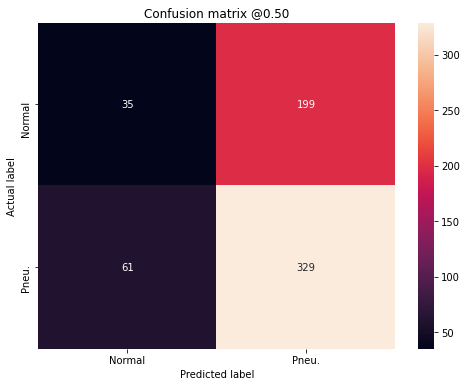

In [ ]:
plot_cm(test_data_gen.labels, test_preds, p=0.5)

## Data Augmentation + Class_weight

In [ ]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

In [ ]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 5216 images belonging to 2 classes.


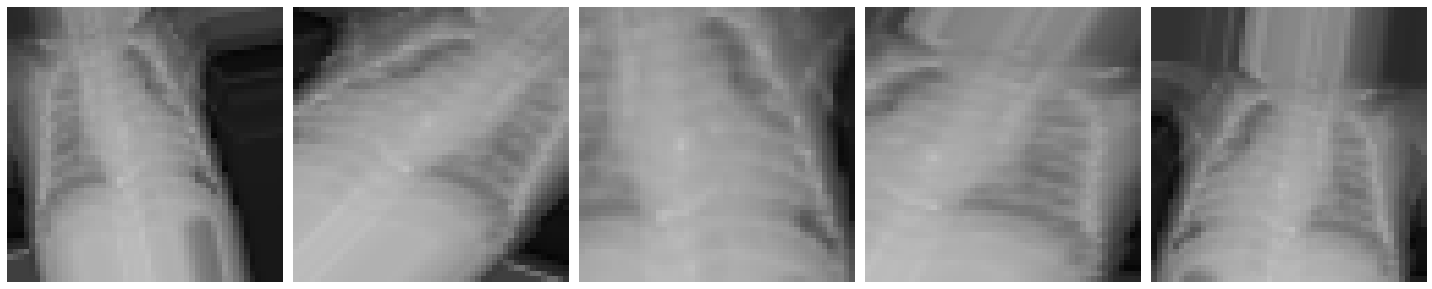

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [ ]:
model_new = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    tf.keras.layers.Dropout(0.2),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [ ]:
model_new.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [ ]:
history = model_new.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/5
326/326 [==============================] - 71s 219ms/step - loss: 0.5705 - accuracy: 0.7421 - val_loss: 0.8133 - val_accuracy: 0.5000
Epoch 2/5
326/326 [==============================] - 71s 218ms/step - loss: 0.5704 - accuracy: 0.7429 - val_loss: 0.8133 - val_accuracy: 0.5000
Epoch 3/5
326/326 [==============================] - 71s 217ms/step - loss: 0.5704 - accuracy: 0.7429 - val_loss: 0.8133 - val_accuracy: 0.5000
Epoch 4/5
326/326 [==============================] - 71s 218ms/step - loss: 0.5704 - accuracy: 0.7429 - val_loss: 0.8133 - val_accuracy: 0.5000
Epoch 5/5
326/326 [==============================] - 71s 218ms/step - loss: 0.5704 - accuracy: 0.7429 - val_loss: 0.8133 - val_accuracy: 0.5000


In [ ]:
test_preds_with_dataAug = model_new.predict(test_data_gen)

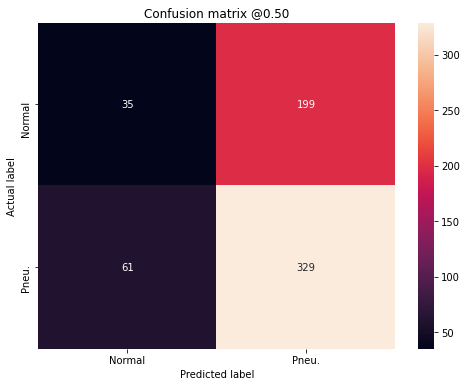

In [ ]:
plot_cm(test_data_gen.labels, test_preds, p=0.5)

### SAVE WEIGHT

In [ ]:
#pip install -q pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model_2.save('saved_model/my_model') 


INFO:tensorflow:Assets written to: saved_model/my_model/assets


#Load model

In [ ]:
new_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
new_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          multiple                  0         
_________________________________________________________________
dense_30 (Dense)             multiple                  19267712  
_________________________________________________________________
dense_31 (Dense)             multiple                  8256      
_________________________________________________________________
dropout_12 (Dropout)         multiple                  0         
_________________________________________________________________
dense_32 (Dense)             multiple                  2080      
_________________________________________________________________
dense_33 (Dense)             multiple                  528       
_________________________________________________________________
dropout_13 (Dropout)         multiple                 

In [ ]:
# Evaluate the restored model
new_model.evaluate(full_test_ds, verbose=2)


39/39 - 4s - loss: 1.1355 - tp: 382.0000 - fp: 126.0000 - tn: 108.0000 - fn: 8.0000 - accuracy: 0.7853 - precision: 0.7520 - recall: 0.9795 - auc: 0.8290


[1.1354529857635498,
 382.0,
 126.0,
 108.0,
 8.0,
 0.7852563858032227,
 0.751968502998352,
 0.9794871807098389,
 0.8290488123893738]